In [2]:
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

In [3]:
data = pd.read_pickle("../data/transactions.pkl")

X = data.drop(['fraud'],axis=1)
y = data['fraud']

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_valid.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

def add_graph_features(df):
    G = nx.from_pandas_edgelist(df, 'customer', 'merchant', create_using=nx.Graph())
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    pagerank = nx.pagerank(G)

    df['degree_centrality'] = df['customer'].map(degree_centrality).fillna(0)
    df['closeness_centrality'] = df['customer'].map(closeness_centrality).fillna(0)
    df['betweenness_centrality'] = df['customer'].map(betweenness_centrality).fillna(0)
    df['pagerank'] = df['customer'].map(pagerank).fillna(0)
    return df

X_train = add_graph_features(X_train)
X_valid = add_graph_features(X_valid)
X_test = add_graph_features(X_test)

Training set size: 356785 samples
Validation set size: 118929 samples
Testing set size: 118929 samples


In [5]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the neural network architecture
class FraudClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FraudClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Convert DataFrames to NumPy arrays
X_train_np = X_train.values
X_valid_np = X_valid.values
X_test_np = X_test.values
y_train_np = y_train.values
y_valid_np = y_valid.values
y_test_np = y_test.values

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_valid_tensor = torch.tensor(X_valid_np, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1).to(device)
y_valid_tensor = torch.tensor(y_valid_np, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1).to(device)

In [7]:
# Initialize the model
input_dim = X_train.shape[1]
model = FraudClassifier(input_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(X_train_tensor.size(0))
    X_train_tensor = X_train_tensor[perm]
    y_train_tensor = y_train_tensor[perm]

    for i in range(0, X_train_tensor.size(0), batch_size):
        # Get the batch
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    with torch.no_grad():
        outputs = model(X_valid_tensor)
        predicted = (outputs >= 0.5).float()
        accuracy = accuracy_score(y_valid_tensor.cpu(), predicted.cpu())
        precision = precision_score(y_valid_tensor.cpu(), predicted.cpu())
        recall = recall_score(y_valid_tensor.cpu(), predicted.cpu())
        f1 = f1_score(y_valid_tensor.cpu(), predicted.cpu())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Evaluate on test set
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).float()
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
    precision = precision_score(y_test_tensor.cpu(), predicted.cpu())
    recall = recall_score(y_test_tensor.cpu(), predicted.cpu())
    f1 = f1_score(y_test_tensor.cpu(), predicted.cpu())

print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Epoch [1/100], Loss: 0.0038, Accuracy: 0.9894, Precision: 0.9710, Recall: 0.0962, F1-score: 0.1750
Epoch [2/100], Loss: 0.0013, Accuracy: 0.9909, Precision: 0.9250, Recall: 0.2391, F1-score: 0.3799
Epoch [3/100], Loss: 0.0090, Accuracy: 0.9933, Precision: 0.8472, Recall: 0.5255, F1-score: 0.6486
Epoch [4/100], Loss: 0.0030, Accuracy: 0.9919, Precision: 0.9384, Recall: 0.3281, F1-score: 0.4862
Epoch [5/100], Loss: 0.0001, Accuracy: 0.9911, Precision: 0.9127, Recall: 0.2627, F1-score: 0.4080
Epoch [6/100], Loss: 0.0089, Accuracy: 0.9934, Precision: 0.8875, Recall: 0.4982, F1-score: 0.6382
Epoch [7/100], Loss: 0.0157, Accuracy: 0.9935, Precision: 0.8547, Recall: 0.5363, F1-score: 0.6590
Epoch [8/100], Loss: 0.0019, Accuracy: 0.9918, Precision: 0.6549, Recall: 0.6403, F1-score: 0.6475
Epoch [9/100], Loss: 0.1199, Accuracy: 0.9931, Precision: 0.8134, Recall: 0.5384, F1-score: 0.6479
Epoch [10/100], Loss: 0.0186, Accuracy: 0.9923, Precision: 0.7008, Recall: 0.6001, F1-score: 0.6466
Epoch [11

In [8]:
thresholds = torch.linspace(0, 1, 101).to(device)  # Generate thresholds from 0 to 1
best_threshold = None
best_precision = 0.0
best_recall = 0.0

with torch.no_grad():
    outputs = model(X_valid_tensor)
    
    for threshold in thresholds:
        predicted = (outputs >= threshold).float()
        precision = precision_score(y_valid_tensor.cpu(), predicted.cpu())
        recall = recall_score(y_valid_tensor.cpu(), predicted.cpu())
        
        if abs(precision - 0.66) < abs(best_precision - 0.66):
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

print(f"Best threshold: {best_threshold:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}")

# Evaluate on test set using the best threshold
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs >= best_threshold).float()
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
    precision = precision_score(y_test_tensor.cpu(), predicted.cpu())
    recall = recall_score(y_test_tensor.cpu(), predicted.cpu())
    f1 = f1_score(y_test_tensor.cpu(), predicted.cpu())

print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Best threshold: 0.3100, Precision: 0.6626, Recall: 0.6935
Test Accuracy: 0.9928, Precision: 0.6923, Recall: 0.7050, F1-score: 0.6986


In [10]:
# Get feature importances from the model
importance = model.fc1.weight.abs().mean(dim=0).detach().cpu().numpy()
importance_df = pd.Series(importance, index=X_train.columns)
importance_df = (importance_df / importance_df.sum()) * 100  # Normalize to percentage
sorted_df = importance_df.sort_values(ascending=False)

# ROC Curve calculation
y_test = y_test_tensor.cpu().numpy()
y_prob = outputs.detach().cpu().numpy()
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve calculation
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

# Confusion Matrix calculation
y_pred = predicted.cpu().numpy()
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", cm)

Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    117512
         1.0       0.69      0.71      0.70      1417

    accuracy                           0.99    118929
   macro avg       0.84      0.85      0.85    118929
weighted avg       0.99      0.99      0.99    118929

Confusion Matrix: 
 [[117068    444]
 [   418    999]]


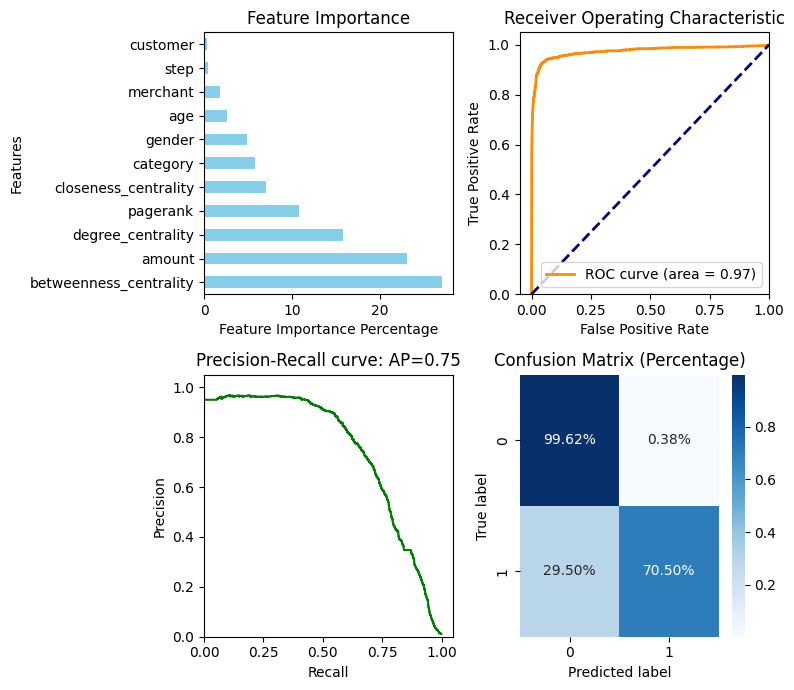

In [11]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))

# Plot Feature Importances
sorted_df.plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Feature Importance')
axes[0, 0].set_xlabel('Feature Importance Percentage')
axes[0, 0].set_ylabel('Features')

# Plot ROC Curve
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 1].set_xlim([-0.05, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Receiver Operating Characteristic')
axes[0, 1].legend(loc="lower right")

# Plot Precision-Recall Curve
axes[1, 0].step(recall, precision, where='post', color='green')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlim([0.0, 1.05])
axes[1, 0].set_title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Plot Confusion Matrix
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix (Percentage)')
axes[1, 1].set_xlabel('Predicted label')
axes[1, 1].set_ylabel('True label')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()